In [19]:
from __future__ import division
import os
import numpy as np
import pandas as pd

##distance square function - we don't need the square root so we can save computation time
# euclidean distance
def dist_sq(a, b, axis = 0):
    return np.sum((a-b)**2,axis)

##cost function
# Version 1 - 2 list comprehension, no broadcasting
# def cost(c,data):
#     return np.sum([min([euclidean(d,s) for s in c])**2 for d in data])

# Version 2 - 1 list comprehension and one broadcasting
def cost(c,data):
    return np.sum([min(dist_sq(c, d, axis = 1)) for d in data])

#sampling probability function
# Version 1 - 2 list comprehension, no broadcasting
# def smpl_prb(c,data,l):
#     phi_temp = cost(c,data)
#     return np.array([(min([euclidean(d,s) for s in c])**2)*l/phi_temp for d in data])

# Version 2 - 1 list comprehension, 1 broadcasting
def smpl_prb(c,data,l):
    phi_temp = cost(c,data)
    return np.array([(min(dist_sq(c, d, axis = 1)))*l/phi_temp for d in data])


#weight function - propotional to the number of data points have the same specific center
def weight_func(c, data):
    # Find the closet point in c for each point in data
    # Version 1 - 2 list comprehension, no broadcasting
    # min_c = [np.argmin([euclidean(d,s) for s in c]) for d in data];
    # Version 2 - 1 list comprehension, 1 broadcasting
    min_c = [np.argmin(dist_sq(c, d, axis = 1)) for d in data];
    ## number of points which is closest to each s in c
    num_closest = np.array([min_c.count(i) for i in range(len(c))]).astype(float);
    ## return normalized weight
    return num_closest/np.sum(num_closest)


#Kmeans||
#l is oversampling factor

def KmeansParallel_IMSCARED(n_clusters, data, l):
    if n_clusters <= 0 or not(isinstance(n_clusters,int)):
        sys.exit("n_cluster is not positive integer")
    
    if l <= 0: 
        sys.exit("l is not positive")
    
    if len(data) < n_clusters: 
        sys.exit("number of data is less than n_clusters")
    
    num = len(data)
    
    #Step 1 - uniformly sample one point
    c = np.array(data[np.random.choice(range(num),1),])
    
    #Step 2 - cost
    phi = cost(c,data)
    
    #Step 3~6 - get potential centers
    for i in range(np.ceil(np.log(phi)).astype(int)):
        c_add = data[smpl_prb(c,data,l)>np.random.uniform(size = num),]
        c = np.concatenate((c,c_add))
        
    #Step 7
    # Find the closet point in c for each point in data
    ##weight
    weight = weight_func(c, data)
    
    #Step 8 - recluster by kmeans++ initialization
    c_final = data[np.random.choice(range(len(c)),size=1,p=weight),]
    data_final = c
    for i in range(n_clusters-1):
        new_prb = smpl_prb(c_final,data_final,l) * weight
        c_fin_add = data[np.random.choice(range(len(c)),size=1,p=new_prb/np.sum(new_prb)),]
        c_final = np.concatenate((c_final,c_fin_add))
    return c_final

In [6]:
from simulatedData import generate_data

In [14]:
test_data = generate_data(4, 100, 2, 10000)

In [46]:
test_clus = KmeansParallel_IMSCARED(4, test_data, 10)

In [47]:
x = test_clus[:,0]
y = test_clus[:,1]
test_clus

array([[ -7.31024213,  -2.54772572],
       [ 14.59470402, -10.94906936],
       [ -7.41863026,  -3.05813811],
       [  1.03119969,  12.61962436]])

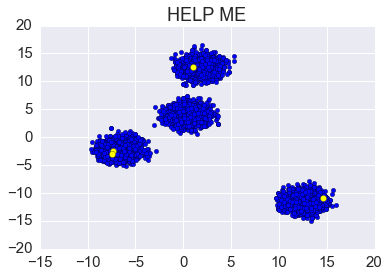

In [48]:
plt.figure()
plt.scatter(test_data[:,0], test_data[:,1], cmap='Accent')
plt.scatter(x, y, s=40, marker="o", c="yellow")
plt.title("HELP ME")
pass